## Notes:
- Use escape velocity, unless smaller than 5 km/s, then set to 5 km/s (argued based on Kim+2018)

- STILL NEED TO REPROJECT THE CO DATA TO THE CII MAP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from scipy.optimize import curve_fit

import gaussianFunctions as gauss

In [2]:
#### User input ####

## Region to be cut out in the Orion map
x1_orion = 260
x2_orion = 260+720
y1_orion = 20
y2_orion = 20+640

## minimum value for [CII]
min_CII = 50


## regions to be analysed
## 0: escape velocity used
## 1: minimal velocity to plot the spectrum
## 2: maximal velocity to plot the spectrum
## 3: Name of the region
names = {
    'RCW36_CII_final_20_8_0p5_clean': [5.0, -25., 30., 'RCW36'], # 4.0
    'W40_CII_final_20_8_0p5_clean': [5.0, -25., 30, 'W40'],  # 3.9
    'RCW120_CII_final_20_8_0p5_clean': [5.0, -35., 15., 'RCW120'], # 10.7
    #'OrionA_CII_final_20_8_0p5_clean': [5.0 , 'M42'], # 3.0
    'NGC7538_CII_final_20_8_0p5_clean': [5.5, -90., -25., 'NGC7538'],
    'RCW79_CII_final_20_8_0p5_clean': [5.0, -80., -20., 'RCW79'], #2.6
    'm16_CII_final_20_8_0p5_clean': [5.0, 0., 50., 'M16'], # 4.0
    'm17_CII_final_20_8_0p5_clean': [6.9, -25., 60., 'M17'],
    'RCW49_CII_final_20_8_0p5_clean': [5.0, -35., 40., 'RCW49']
}

#### End User input

In [3]:
## Functions


## get the velocity array
def get_vel_arr(length, crval3, dv, crpix3, imin):
    vel_arr = [crval3 + dv*(i-crpix3) for i in range(imin, imin+length)]
    
    return vel_arr


## Convert the velocity to a pixel index based on the provided header information
def vel_to_pixel(vel, crval, dv, crpix):
    return int((vel - crval)/dv + crpix + 0.5)


## Get the data and the velocity axis
def get_data_and_velAxis(path, vlims = None):
    ## Open the fits file
    hdu = pyfits.open(path)
    hdu.info()
    
    ## Get the data and header
    data = hdu[0].data
    header = hdu[0].header
    
    ## remove the forth dimensional axis
    if(len(data.shape) == 4):
        data = data[0]
    
    ## Extract the information on the velocity axis
    crval3, dv, crpix3 = header['CRVAL3']/1000., header['CDELT3']/1000., header['CRPIX3']
    
    ## remove all unnecessary velocity bins
    imin = 0
    if(vlims is not None):
        imin = vel_to_pixel(vlims[0], crval3, dv, crpix3)
        imax = vel_to_pixel(vlims[1], crval3, dv, crpix3)
        if(dv >= 0):
            data = data[imin:imax, :, :]
        else:
            data = data[imax:imin, :, :]
            
    ## get the velocity array
    vel_arr = get_vel_arr(data.shape[0], crval3, dv, crpix3, imin)
    if(dv < 0):
        vel_arr = get_vel_arr(data.shape[0], crval3, dv, crpix3, imax)
        
    
    return data, vel_arr


## returns an array with the fitted gaussian function based on the popt values
def get_fitted_arrs(popt, vmin, vmax, dv):
    ## create the velocity array
    arr_len = int((vmax - vmin)/dv + 0.5)
    vel_arr = [vmin + i*dv for i in range(0, arr_len)]
    
    ## create the fitted spectrum
    spec_arr = []
    if(len(popt) == 3):
        spec_arr = [gauss.gaussian1d(v, popt[0], popt[1], popt[2]) for v in vel_arr]
    else:
        raise valueError('This number of fitted components is not included in the code')
    
    return vel_arr, spec_arr
    


## perform the plotting
def plot_spectra_with_vesc(reg_name, vel_arr, spec, vel_arr_CO, spec_CO, vel_arr_13CO, spec_13CO, vlims = None, popt = None, vesc = None):
    plt.clf()
    
    ## plot the spectra
    plt.step(vel_arr, spec, 'r-', label = '[CII]')
    plt.step(vel_arr_CO, spec_CO, 'b-', label = '$^{12}$CO')
    plt.step(vel_arr_13CO, spec_13CO, 'g-', label = '$^{13}$CO')
    
    ## plot a horizontal line
    plt.axhline(y = 0, color = 'k', linestyle = '--')
    
    ## Add fitted result to the 13CO line
    if(popt is not None):
        v_fit, spec_fit = get_fitted_arrs(popt, np.nanmin(vel_arr_13CO), np.nanmax(vel_arr_13CO), 0.1)
        plt.plot(v_fit, spec_fit, 'k-')
        
    ## Add the escape velocity
    if(popt is not None and vesc is not None):
        if reg_name == 'RCW79': plt.axvline(x = -38., color = 'gray', linestyle = '--')
        if reg_name == 'M16': plt.axvline(x = 30., color = 'gray', linestyle = '--')
        if reg_name == 'M17': plt.axvline(x = 37., color = 'gray', linestyle = '--')
        if reg_name == 'RCW49': 
            plt.axvline(x = -10., color = 'gray', linestyle = '--')
            plt.axvline(x = 20., color = 'gray', linestyle = '--')
            
        plt.axvline(x = popt[1] + vesc, color = 'gray', linestyle = ':')
        plt.axvline(x = popt[1] - vesc, color = 'gray', linestyle = ':')
    
    ## handle the axes limits
    if(vlims is not None):
        plt.xlim(vlims)
    plt.ylim([-1., np.nanmax(spec) + 0.5])
    
    ## set the axes labels
    plt.xlabel('v (km s$^{-1}$)')
    plt.ylabel('T$_{mb}$ (K)')
    
    plt.legend()
    
    plt.show()


## Calculates the percentage in the blue and red wings
## NOTE: IN COUNT ONLY CONSIDERS POSITIVE VALUES
def calc_wing_frac(vel_arr, spec, v_b, v_r):
    count_b, count, count_r = 0., 0., 0.
    
    ## loop over all intensities in the spectrum
    for v, intens in zip(vel_arr, spec):
        if(intens > 0.):
            ## count total intensity
            count += intens
            
            ## count for the blue wing
            if(v < v_b):
                count_b += intens
            
            ## count for the red wing
            if(v > v_r):
                count_r += intens
            
    return count_b/count, count_r/count


## Calculate the intensity weighted outflow velocity
## NOTE: IN COUNT ONLY CONSIDERS POSITIVE VALUES
def calc_outflow_vel(vel_arr, spec, v_b, v_r, v_cent):
    sum_vel = 0.
    denom = 0.
    
    ## loop over all intensities
    for v, intens in zip(vel_arr, spec):
        if((intens > 0.) and (v < v_b or v > v_r)):
            sum_vel += intens*abs(v - v_cent)
            denom += intens
    
    return sum_vel/denom

Filename: ../data_timescale/RCW36_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (108, 55, 901)   float32   
Filename: ../data_timescale/CO_data/RCW36_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (145, 111, 2376, 1)   int32 (rescales to float64)   
Filename: ../data_timescale/CO_data/RCW36_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (135, 107, 2500, 1)   int32 (rescales to float64)   


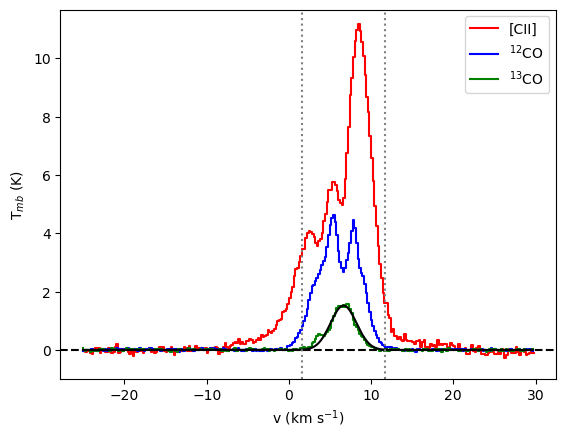

Fraction of the [CII] emission in blueshifted escape range: 0.1203657338132678
Fraction of the [CII] emission in redshifted escape range: 0.04734503743449549
The intensity weighted outflow velocity is: 8.051651262509571
The central velocity of the molecular cloud is: 6.645984334040435
The velocity intervals for the blue and red wings:
1.65 km/s, 11.65 km/s
Filename: ../data_timescale/W40_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (231, 233, 400)   float32   
Filename: ../data_timescale/CO_data/W40_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (248, 218, 1590)   float32   
Filename: ../data_timescale/CO_data/W40_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (238, 209, 1666)   float32   


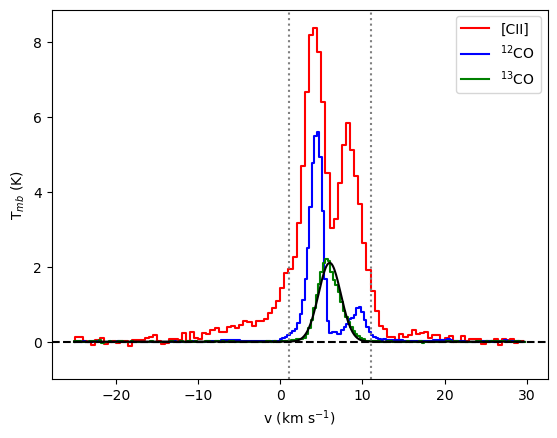

Fraction of the [CII] emission in blueshifted escape range: 0.12653651561151402
Fraction of the [CII] emission in redshifted escape range: 0.054162604075633655
The intensity weighted outflow velocity is: 9.91113582905378
The central velocity of the molecular cloud is: 6.01968348808743
The velocity intervals for the blue and red wings:
1.02 km/s, 11.02 km/s
Filename: ../data_timescale/RCW120_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (136, 137, 320)   float32   
Filename: ../data_timescale/CO_data/RCW120_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (113, 113, 4756, 1)   int32 (rescales to float64)   
Filename: ../data_timescale/CO_data/RCW120_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (108, 109, 5000, 1)   int32 (rescales to float64)   


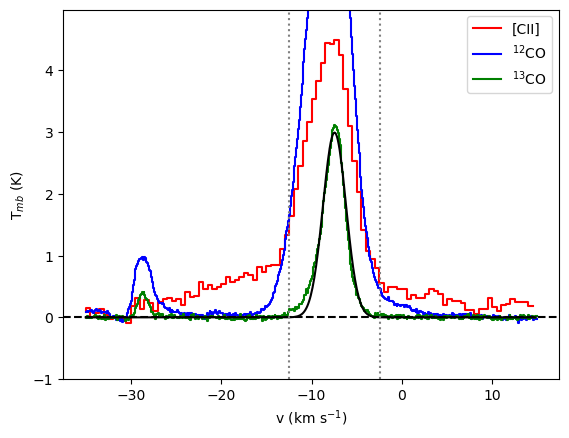

Fraction of the [CII] emission in blueshifted escape range: 0.21731852310883734
Fraction of the [CII] emission in redshifted escape range: 0.11534200101707288
The intensity weighted outflow velocity is: 11.677261321997358
The central velocity of the molecular cloud is: -7.465880443437479
The velocity intervals for the blue and red wings:
-12.47 km/s, -2.47 km/s
Filename: ../data_timescale/NGC7538_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (108, 104, 901)   float32   
Filename: ../data_timescale/CO_data/NGC7538_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (307, 217, 592, 1)   int32 (rescales to float64)   
Filename: ../data_timescale/CO_data/NGC7538_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (307, 217, 566, 1)   int32 (rescales to float64)   


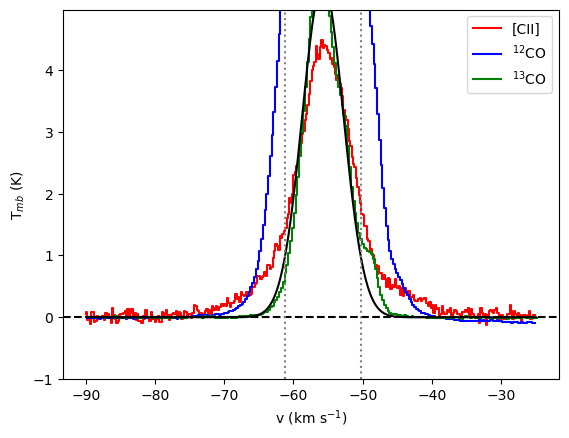

Fraction of the [CII] emission in blueshifted escape range: 0.12674661465157855
Fraction of the [CII] emission in redshifted escape range: 0.15321306128739917
The intensity weighted outflow velocity is: 10.67304670867048
The central velocity of the molecular cloud is: -55.75763998816504
The velocity intervals for the blue and red wings:
-61.26 km/s, -50.26 km/s
Filename: ../data_timescale/RCW79_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
Filename: ../data_timescale/CO_data/RCW79_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (189, 184, 476)   float32   
Filename: ../data_timescale/CO_data/RCW79_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (190, 185, 500)   float32   


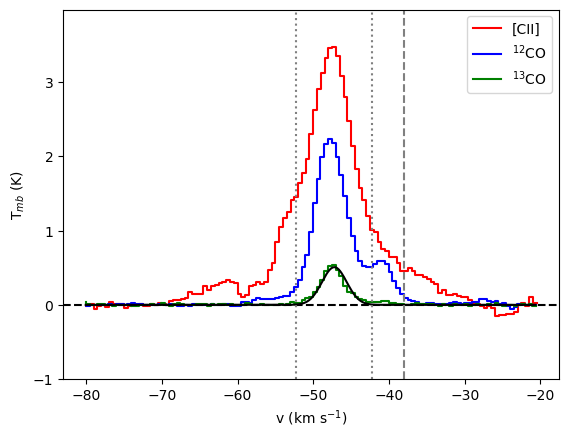

Fraction of the [CII] emission in blueshifted escape range: 0.17040717211163797
Fraction of the [CII] emission in redshifted escape range: 0.06854153999347841
The intensity weighted outflow velocity is: 10.82992523828431
The central velocity of the molecular cloud is: -47.21645865810043
The velocity intervals for the blue and red wings:
-52.22 km/s, -42.22 km/s
Filename: ../data_timescale/m16_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (295, 283, 200)   float32   
Filename: ../data_timescale/CO_data/M16_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (255, 250, 4518)   float32   
Filename: ../data_timescale/CO_data/M16_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (244, 239, 4517)   float32   


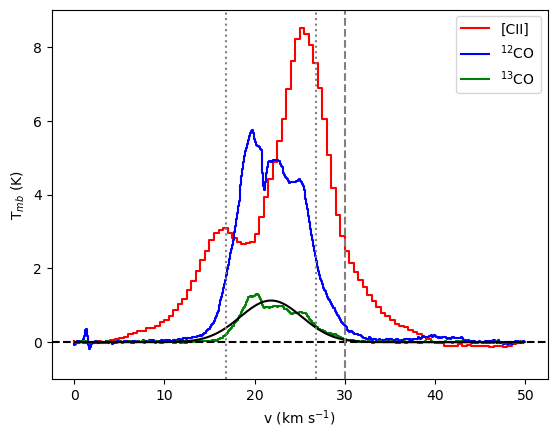

Fraction of the [CII] emission in blueshifted escape range: 0.14699698125855373
Fraction of the [CII] emission in redshifted escape range: 0.09852221351089008
The intensity weighted outflow velocity is: 9.424023631224305
The central velocity of the molecular cloud is: 21.821327197106946
The velocity intervals for the blue and red wings:
16.82 km/s, 26.82 km/s
Filename: ../data_timescale/m17_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (191, 191, 200)   float32   
Filename: ../data_timescale/CO_data/M17_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (210, 212, 2376)   float32   
Filename: ../data_timescale/CO_data/M17_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (201, 203, 2500)   float32   


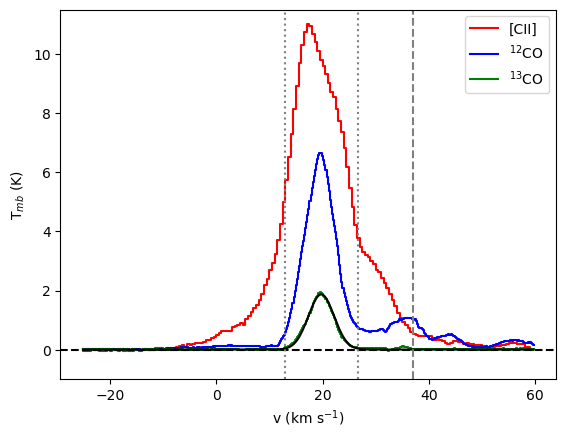

Fraction of the [CII] emission in blueshifted escape range: 0.12948721434427138
Fraction of the [CII] emission in redshifted escape range: 0.03219708312735507
The intensity weighted outflow velocity is: 14.792337122810567
The central velocity of the molecular cloud is: 19.76441154773235
The velocity intervals for the blue and red wings:
12.86 km/s, 26.66 km/s
Filename: ../data_timescale/RCW49_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (177, 254, 400)   float32   
Filename: ../data_timescale/CO_data/RCW49_12CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (231, 226, 951)   float32   
Filename: ../data_timescale/CO_data/RCW49_13CO_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (221, 216, 1000)   float32   


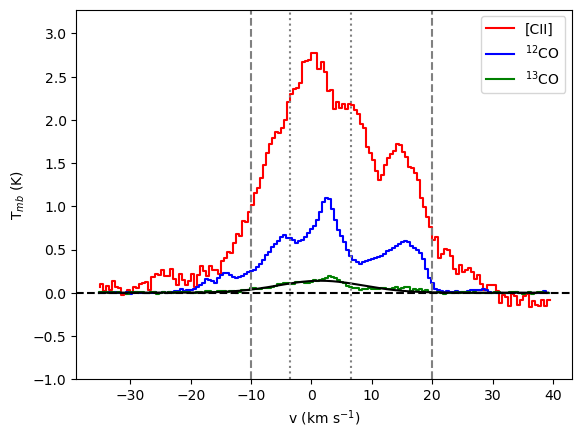

Fraction of the [CII] emission in blueshifted escape range: 0.09232851110125323
Fraction of the [CII] emission in redshifted escape range: 0.04769521061560378
The intensity weighted outflow velocity is: 19.688382722491593
The central velocity of the molecular cloud is: 1.5011153218540925
The velocity intervals for the blue and red wings:
-3.5 km/s, 6.5 km/s


In [4]:
## Loop over the regions
esc_frac_b = []
esc_frac_r = []
av_esc_vel = []
reg_names = []
for name in names.keys():
    ## get the [CII] data
    data, vel_arr = get_data_and_velAxis('../data_timescale/'+name+'.fits', vlims = [names[name][1], names[name][2]])
    
    ## get the CO data
    data_CO, vel_arr_CO = get_data_and_velAxis('../data_timescale/CO_data/{reg}_12CO_final.fits'.format(reg = names[name][-1]), 
                                                vlims = [names[name][1], names[name][2]],
                                                )
    
    ## get the 13CO data
    data_13CO, vel_arr_13CO = get_data_and_velAxis('../data_timescale/CO_data/{reg}_13CO_final.fits'.format(reg = names[name][-1]), 
                                                vlims = [names[name][1], names[name][2]],
                                                )
    
    ## Extract regions of interest
    if(name=='OrionA'):
        data = data[:, y1_orion:y2_orion, x1_orion:x2_orion]
    
    ## get the average spectrum
    spec = np.nanmean(data, axis = (1,2))
    spec_CO = np.nanmean(data_CO, axis = (1,2))
    spec_13CO = np.nanmean(data_13CO, axis = (1,2))
    
    ## fit the 13CO spectrum with an initial guess
    init_guess = [2., vel_arr_13CO[np.argmax(np.array(spec_13CO))], 0.8]
    popt_13, pcov_13 = curve_fit(gauss.gaussian1d, vel_arr_13CO, spec_13CO, p0 = init_guess)
    
    ## perform the plotting
    plot_spectra_with_vesc(names[name][-1], vel_arr, spec, vel_arr_CO, spec_CO, vel_arr_13CO, spec_13CO, popt = popt_13, vesc = names[name][0])
    
    ## the percentage in the wings
    frac_blue, frac_red = calc_wing_frac(vel_arr, spec, popt_13[1] - names[name][0], popt_13[1] + names[name][0])
    
    ## Handle multiple components
    if names[name][-1] == 'RCW79': frac_blue, frac_red = calc_wing_frac(vel_arr, spec, popt_13[1] - names[name][0], -38.)
    if names[name][-1] == 'M16': frac_blue, frac_red = calc_wing_frac(vel_arr, spec, popt_13[1] - names[name][0], 30.)
    if names[name][-1] == 'M17': frac_blue, frac_red = calc_wing_frac(vel_arr, spec, popt_13[1] - names[name][0], 37.)
    if names[name][-1] == 'RCW49': frac_blue, frac_red = calc_wing_frac(vel_arr, spec, -10., 20.)
    
    print('Fraction of the [CII] emission in blueshifted escape range: {frac}'.format(frac = frac_blue))
    print('Fraction of the [CII] emission in redshifted escape range: {frac}'.format(frac = frac_red))
    esc_frac_b.append(frac_blue)
    esc_frac_r.append(frac_red)
    
    ## calculate the weighted outflow velocity
    v_out = calc_outflow_vel(vel_arr, spec, popt_13[1] - names[name][0], popt_13[1] + names[name][0], popt_13[1])
    if names[name][-1] == 'RCW79': v_out = calc_outflow_vel(vel_arr, spec, popt_13[1] - names[name][0], -38., popt_13[1])
    if names[name][-1] == 'M16': v_out = calc_outflow_vel(vel_arr, spec, popt_13[1] - names[name][0], 30., popt_13[1])
    if names[name][-1] == 'M17': v_out = calc_outflow_vel(vel_arr, spec, popt_13[1] - names[name][0], 37., popt_13[1])
    if names[name][-1] == 'RCW49': v_out = calc_outflow_vel(vel_arr, spec, -10., 20., popt_13[1])
    
    print('The intensity weighted outflow velocity is: {v_out}'.format(v_out = v_out))
    print('The central velocity of the molecular cloud is: {v_cent}'.format(v_cent = popt_13[1]))
    print('The velocity intervals for the blue and red wings:')
    print('{v1} km/s, {v2} km/s'.format(v1 = round(popt_13[1] - names[name][0], 2), v2 = round(popt_13[1] + names[name][0], 2)))
    av_esc_vel.append(v_out)
    
    ## store the name of the region
    reg_names.append(names[name][-1])
    
    
    

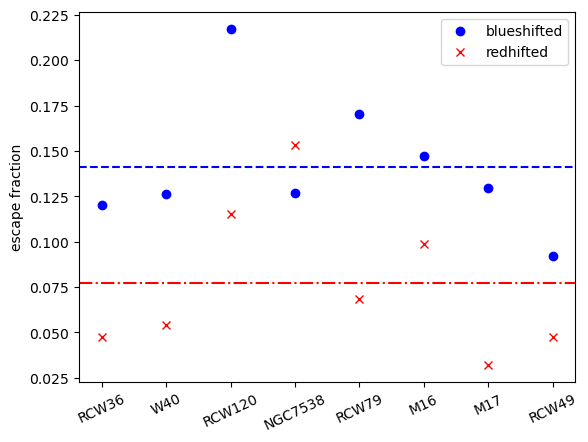

In [5]:
av_frac_b = np.nanmean(esc_frac_b)
av_frac_r = np.nanmean(esc_frac_r)

## plot the results
plt.plot(reg_names, esc_frac_b, 'bo', label = 'blueshifted')
plt.plot(reg_names, esc_frac_r, 'rx', label = 'redhifted')

plt.axhline(y = av_frac_b, color = 'b', linestyle = '--')
plt.axhline(y = av_frac_r, color = 'r', linestyle = '-.')

plt.xticks(rotation = 25)

plt.ylabel('escape fraction')

plt.legend()
plt.show()

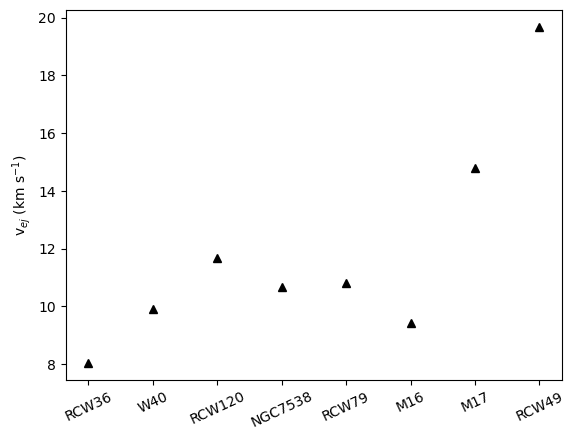

In [6]:
plt.plot(reg_names, av_esc_vel, 'k^')

plt.xticks(rotation = 25)

plt.ylabel('v$_{ej}$ (km s$^{-1}$)')

plt.show()


In [7]:
for reg, v in zip(reg_names, av_esc_vel):
    print('{reg} : {v}'.format(reg = reg, v = v))

RCW36 : 8.051651262509571
W40 : 9.91113582905378
RCW120 : 11.677261321997358
NGC7538 : 10.67304670867048
RCW79 : 10.82992523828431
M16 : 9.424023631224305
M17 : 14.792337122810567
RCW49 : 19.688382722491593
